# NBA All-Star Prediction

In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1) Importing the dataset

In [523]:
df_train = pd.read_csv("C:/Users/hamza/Documents/Best Projects/NBA-All-Stars/ASG_train.csv")

Here we are exploring the dataset, looking at the available features and getting a sense of what data lies within the dataframe.

Our dataset comes from the Basketball Reference website, and it is a complete dataset.

In [525]:
df_train.head()

,Year,Avg. Pace,PLAYER,TEAM,Team Conference Rank,GP,Team GP,W,PTS,REB,...,BLK,TOV,TS%,3PM,DEFWS,USG%,PIE,Prior ASG Appearances,AS Last Year?,Selected?
0,1996,90.1,Michael Jordan,CHI,1,40,40,35,30.9,5.8,...,0.5,1.7,56.4,1.2,0.004,33.6,19.8,10,1,1
1,1996,90.1,Shaquille O'Neal,LAL,3,40,41,28,26.2,13.2,...,3.1,3.1,55.7,0.0,0.003,30.4,18.4,4,1,1
2,1996,90.1,Latrell Sprewell,GSW,7,39,39,16,25.9,4.9,...,0.8,4.0,57.1,2.2,0.001,28.2,14.5,2,0,1
3,1996,90.1,Karl Malone,UTA,4,40,40,27,25.8,10.8,...,0.7,3.1,57.6,0.0,0.003,31.5,20.8,9,1,1
4,1996,90.1,Hakeem Olajuwon,HOU,1,37,41,28,24.1,9.4,...,2.2,3.7,54.8,0.1,0.003,32.2,16.3,11,1,1


Our target feature is All-Star selection, which is in the **Selected?** column. We will be trying to predict All-Star selection based on season stats for future players.

In [527]:
df_to_predict = pd.read_csv("C:/Users/hamza/Documents/Best Projects/NBA-All-Stars/ASG_to_predict.csv")

In [528]:
df_to_predict.head()

,Year,Avg. Pace,PLAYER,TEAM,Team Conference Rank,GP,Team GP,W,PTS,REB,...,STL,BLK,TOV,TS%,3PM,DEFWS,USG%,PIE,Prior ASG Appearances,AS Last Year?
0,2019,100.3,James Harden,HOU,6,41,42,26,36.9,6.3,...,1.6,0.9,4.7,62.1,4.8,0.003,37.0,19.4,7,1
1,2019,100.3,Giannis Antetokounmpo,MIL,1,42,45,36,30.0,12.9,...,1.1,1.0,3.6,61.3,1.6,0.004,36.7,23.3,3,1
2,2019,100.3,Trae Young,ATL,15,40,44,9,29.2,4.7,...,1.2,0.1,4.8,59.4,3.5,0.001,33.8,16.4,0,0
3,2019,100.3,Luka Doncic,DAL,5,39,43,25,29.1,9.7,...,1.0,0.2,4.3,59.7,3.0,0.002,36.1,20.6,0,0
4,2019,100.3,Damian Lillard,POR,10,43,45,19,27.9,4.1,...,1.0,0.3,2.8,60.8,3.6,0.002,28.8,16.2,4,1


### Step 2) Data Cleaning

Let's start by checking our dataset for missing values

In [531]:
missing_values = df_train.isnull().sum()
missing_values

Year                     0
Avg. Pace                0
PLAYER                   0
TEAM                     0
Team Conference Rank     0
GP                       0
Team GP                  0
W                        0
PTS                      0
REB                      0
AST                      0
STL                      0
BLK                      0
TOV                      0
TS%                      0
3PM                      0
DEFWS                    0
USG%                     0
PIE                      0
Prior ASG Appearances    0
AS Last Year?            0
Selected?                0
dtype: int64

We knew our dataset was complete from its source, but we checked to ensure all our data was present regardless.

Now lets get rid of some outliers. There are players who were selected as All-Stars despite not deserving it for either of the following reasons:
- they had a long careerer and were selected as a "farewell"
- they were selected due to favoritism despite being injured and not playing enough games

In [534]:
outliers = [
    ('Dirk Nowitzki', 2018),
    ('Kobe Bryant', 2015),
    ('Kobe Bryant', 2013),
    ('Yao Ming', 2010),
    ('Allen Iverson', 2009),
    ('Allen Iverson', 2008),
    ("Shaquille O'Neal", 2006),
    ('Ray Allen', 2003),
    ('Jamaal Magloire', 2003),
    ('Vince Carter', 2002),
    ('Grant Hill', 2000),
    ('Anfernee Hardaway', 1997),
    ('Anfernee Hardaway', 1996)
]

# Remove outliers from the dataset
df_train = df_train[~df_train[['PLAYER', 'Year']].apply(tuple, axis=1).isin(outliers)]

In [535]:
# Check if any outliers remain
remaining_outliers = df_train[df_train[['PLAYER', 'Year']].apply(tuple, axis=1).isin(outliers)]

if remaining_outliers.empty:
    print("All specified outliers have been removed.")
else:
    print("The following outliers are still present in the dataset:")
    print(remaining_outliers)

All specified outliers have been removed.


Now lets remove all players who appeared in less than 7 games and fix playing percentages.

In [537]:
for i, df in enumerate([df_train, df_to_predict]):
    # Create a clean copy of the DataFrame before modifying
    df = df.copy()
    
    # Drop any player who appeared in less than 7 games
    df = df[df['GP'] >= 7]

    # The % of team's games the player played in
    df['Play Pct.'] = (df['GP'] / df['Team GP']).map(lambda pct: min(pct, 1))

    # Normalize via league average pace for that year
    for col in ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', '3PM']:
        df['Adjusted ' + col] = df[col] / df['Avg. Pace']
    
    # Save the updated DataFrame back to the original variable
    if i == 0:
        df_train = df
    else:
        df_to_predict = df

Our data cleaning steps are now complete. Lets conduct some EDA now.

### Step 3) Exploratory Data Analysis (EDA)

In [540]:
df_train.describe()

,Year,Avg. Pace,Team Conference Rank,GP,Team GP,W,PTS,REB,AST,STL,...,AS Last Year?,Selected?,Play Pct.,Adjusted PTS,Adjusted REB,Adjusted AST,Adjusted STL,Adjusted BLK,Adjusted TOV,Adjusted 3PM
count,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,...,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000,8754.000000
mean,2007.667352,92.803256,7.873658,30.619146,40.382225,15.269134,8.645625,3.781688,1.899966,0.687366,...,0.060886,0.063628,0.760838,0.093178,0.040784,0.020480,0.007416,0.004843,0.013802,0.006257
std,6.506509,2.592216,4.290575,10.924448,5.577933,8.015080,6.010543,2.559067,1.839515,0.463495,...,0.239136,0.244103,0.249420,0.064811,0.027650,0.019853,0.005018,0.005534,0.008932,0.007277
min,1996.000000,90.100000,1.000000,7.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.145833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2002.000000,90.900000,4.000000,22.000000,40.000000,9.000000,3.900000,1.900000,0.600000,0.300000,...,0.000000,0.000000,0.589744,0.042242,0.020652,0.006572,0.003330,0.001099,0.007000,0.000000
50%,2008.000000,92.000000,8.000000,34.000000,41.000000,15.000000,7.200000,3.200000,1.300000,0.600000,...,0.000000,0.000000,0.853659,0.077670,0.034079,0.014024,0.006522,0.003236,0.011944,0.003300
75%,2013.000000,93.900000,12.000000,40.000000,43.000000,21.000000,12.200000,5.000000,2.500000,0.900000,...,0.000000,0.000000,0.975610,0.130862,0.053905,0.027203,0.009923,0.006390,0.018785,0.010741
max,2018.000000,100.000000,15.000000,48.000000,48.000000,39.000000,35.700000,16.500000,13.100000,3.000000,...,1.000000,1.000000,1.000000,0.384530,0.183130,0.142237,0.032223,0.048405,0.060166,0.053000


Lets check the distribution of our target feature, All-Star selection, which is in the **Selected?** column.

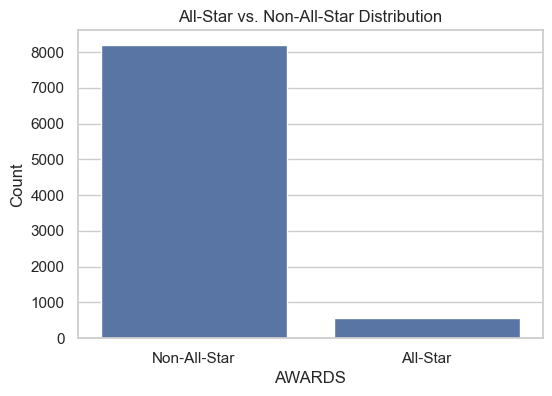

In [542]:
class_distribution = df_train['Selected?'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title("All-Star vs. Non-All-Star Distribution")
plt.xlabel("AWARDS")
plt.ylabel("Count")
plt.xticks([0, 1], ["Non-All-Star", "All-Star"])
plt.show()

In [543]:
df_train.columns

Index(['Year', 'Avg. Pace', 'PLAYER', 'TEAM', 'Team Conference Rank', 'GP',
       'Team GP', 'W', 'PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'TS%', '3PM',
       'DEFWS', 'USG%', 'PIE', 'Prior ASG Appearances', 'AS Last Year?',
       'Selected?', 'Play Pct.', 'Adjusted PTS', 'Adjusted REB',
       'Adjusted AST', 'Adjusted STL', 'Adjusted BLK', 'Adjusted TOV',
       'Adjusted 3PM'],
      dtype='object')

Now lets see the distribution of **Points, Assists, and Rebounds** as well as how All-Stars compare VS non-All-Stars in those categories

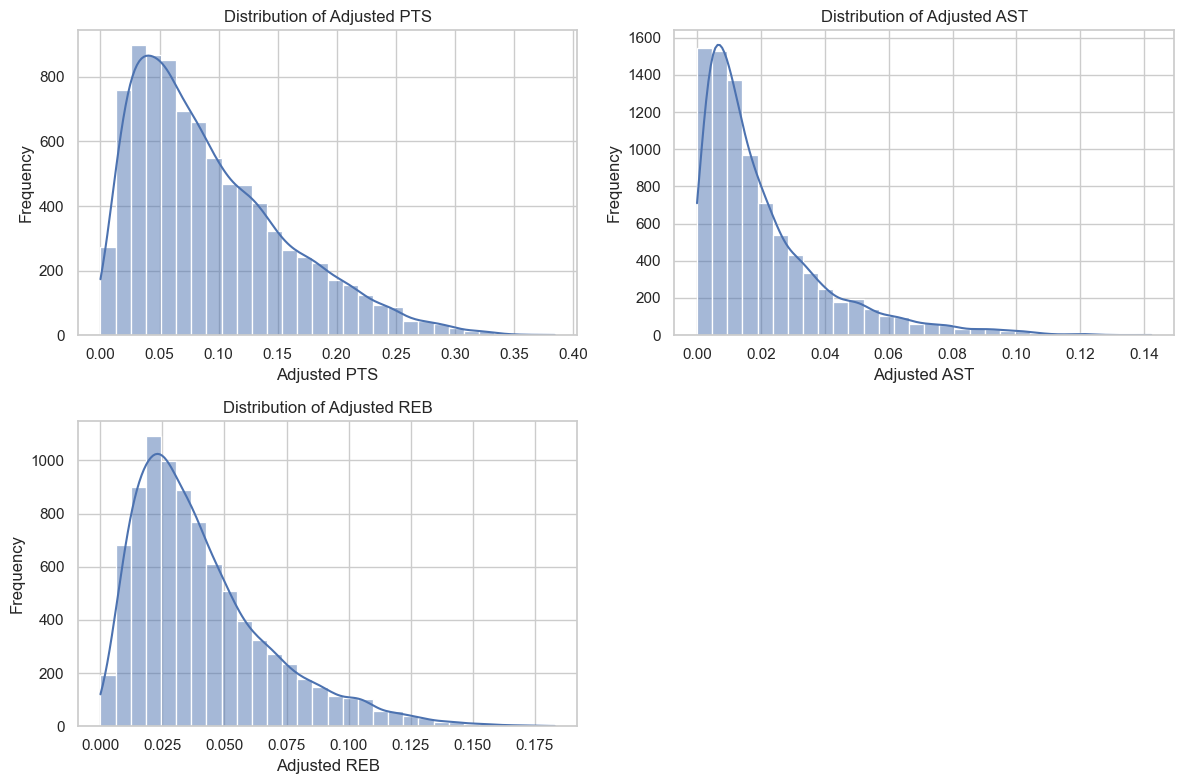

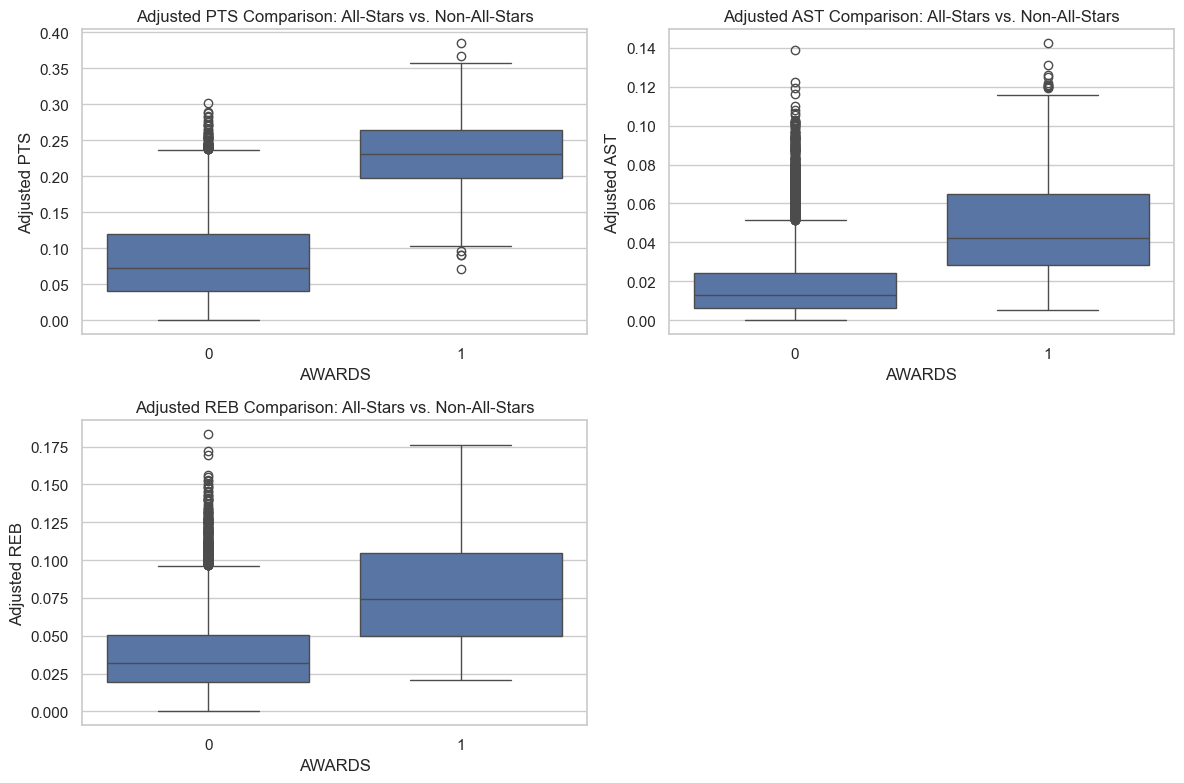

In [545]:
# Visualizing the distribution of key features (PTS, AST, REB)
key_features = ['Adjusted PTS', 'Adjusted AST', 'Adjusted REB']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Comparing All-Stars vs. Non-All-Stars for key features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Selected?', y=feature, data=df_train)
    plt.title(f'{feature} Comparison: All-Stars vs. Non-All-Stars')
    plt.xlabel('AWARDS')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

From these visualizations, we can see that:
- PTS (Points per game) is a significant indicator of All-Star selection
- AST (Assists per game) and REB (Rebounds per game) are also significant indicator, but not as significant as PTS

Let's look at some more features.

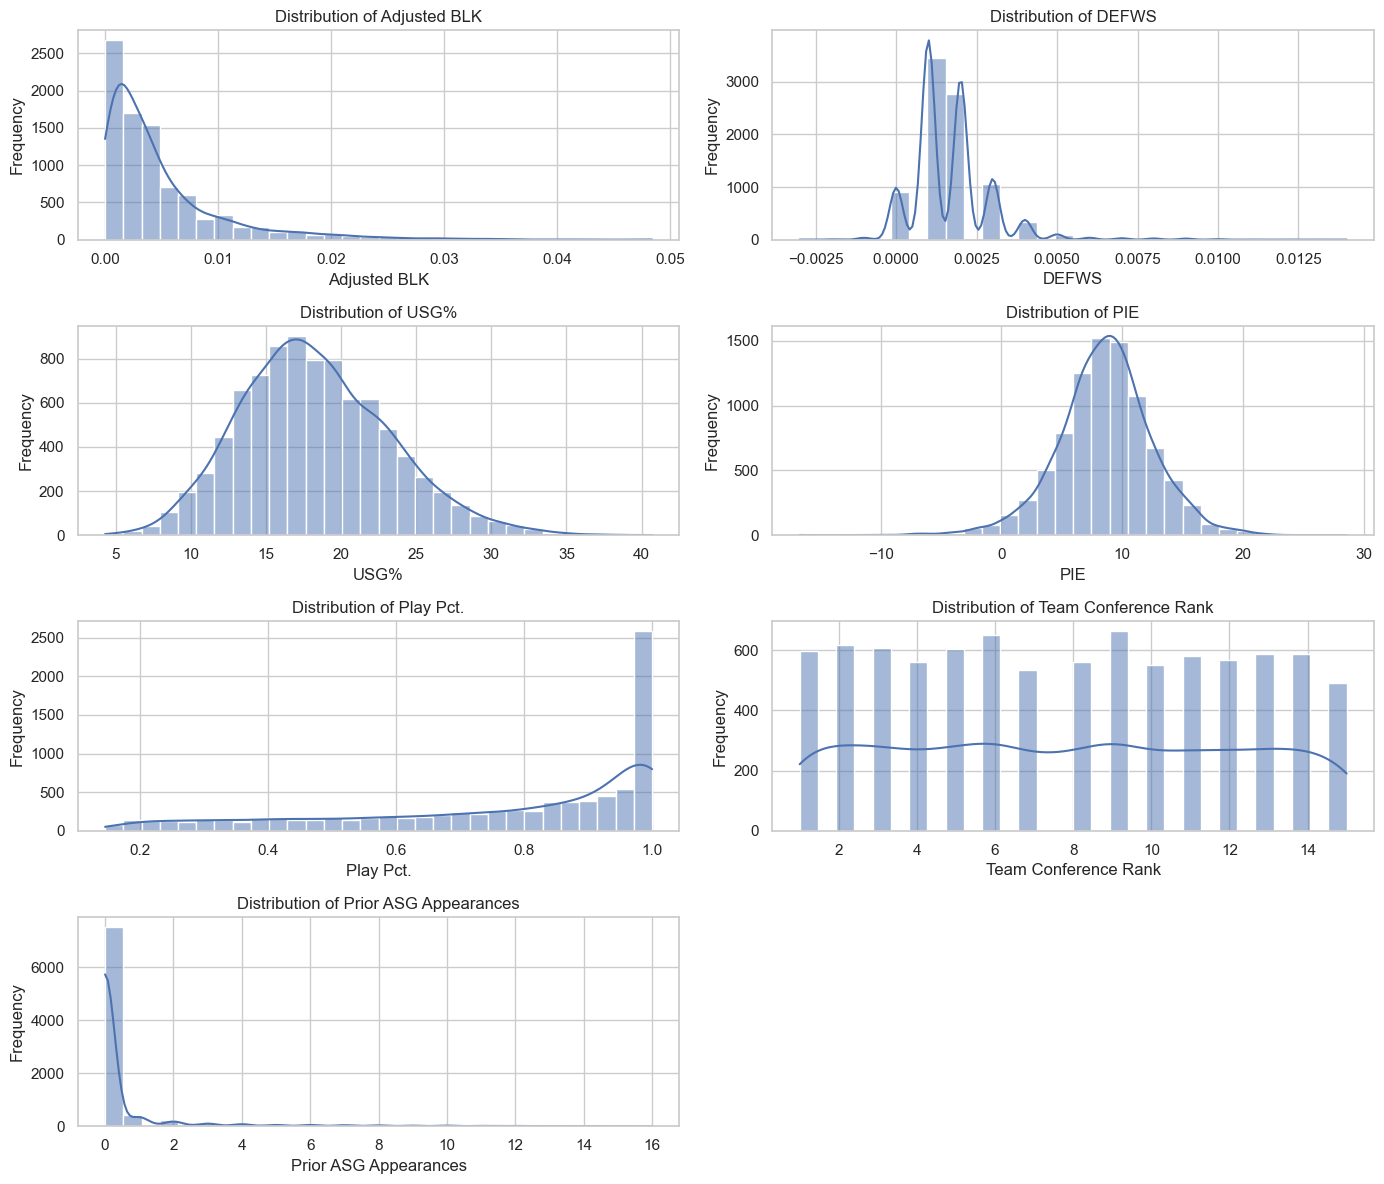

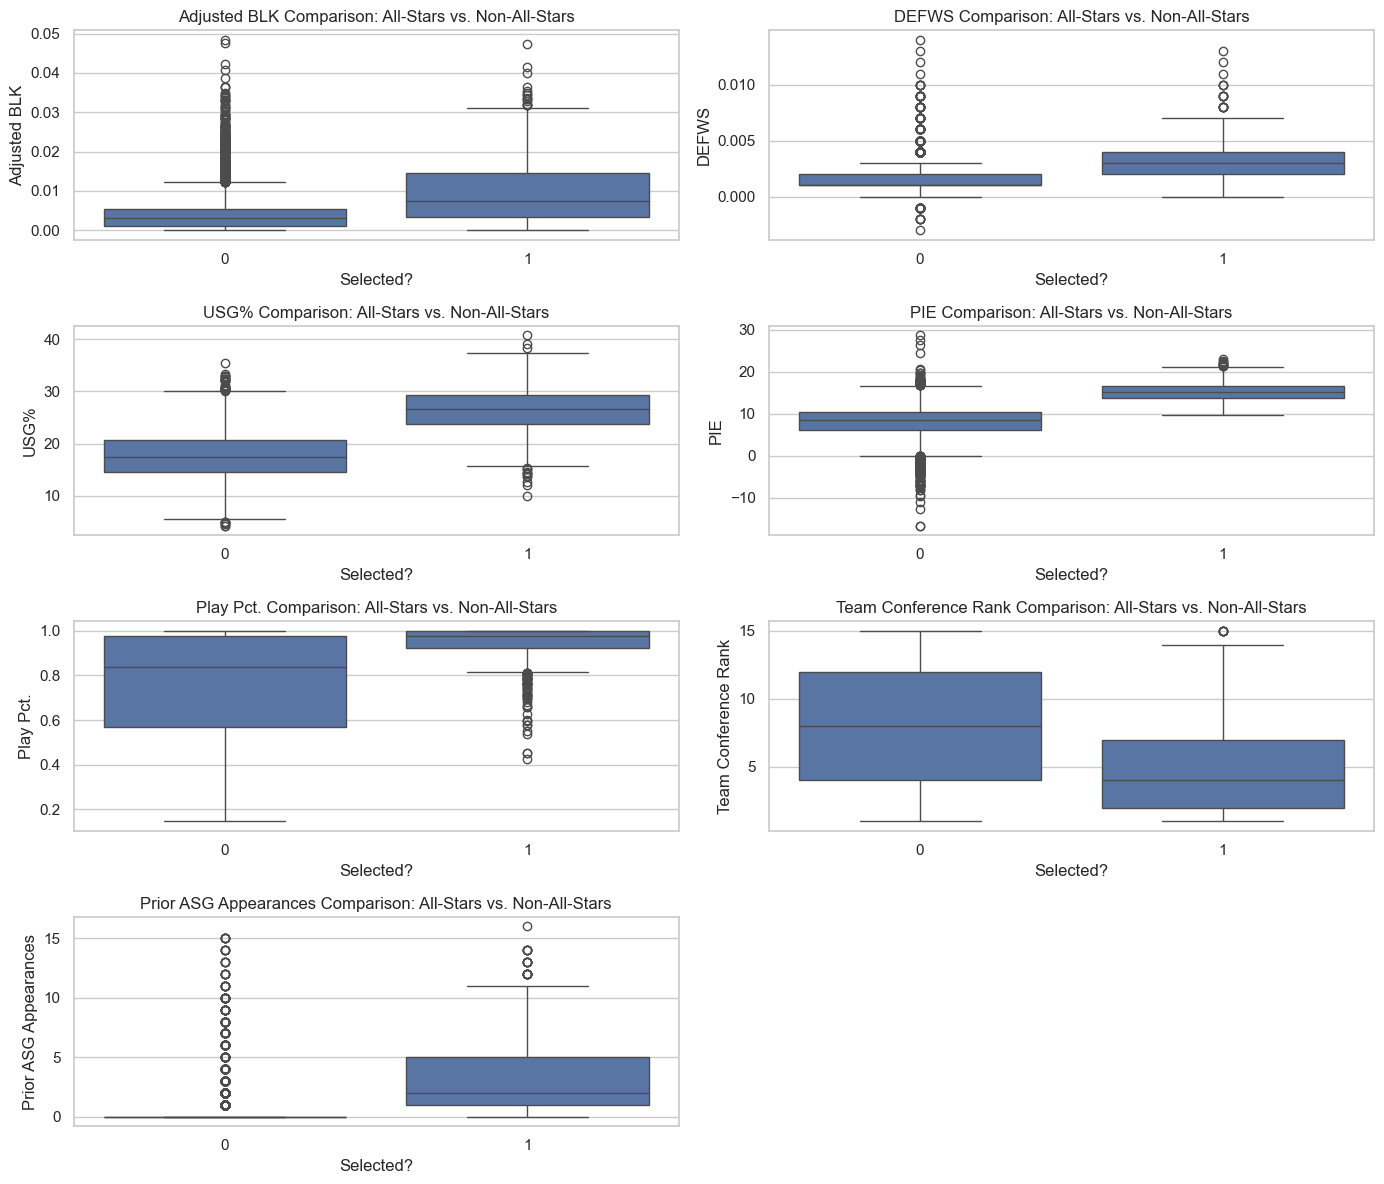

In [547]:
additional_features = ['Adjusted BLK', 'DEFWS', 'USG%', 'PIE', 'Play Pct.', 'Team Conference Rank','Prior ASG Appearances']

# Visualizing distributions of additional features
plt.figure(figsize=(14, 12))
for i, feature in enumerate(additional_features, 1):
    plt.subplot(4, 2, i)  # Updated to 4 rows and 2 columns
    sns.histplot(df_train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Comparing All-Stars vs. Non-All-Stars for additional features
plt.figure(figsize=(14, 12))
for i, feature in enumerate(additional_features, 1):
    plt.subplot(4, 2, i)  # Updated to 4 rows and 2 columns
    sns.boxplot(x='Selected?', y=feature, data=df_train)
    plt.title(f'{feature} Comparison: All-Stars vs. Non-All-Stars')
    plt.xlabel('Selected?')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

From these visualizations, we can see that:
- All-Stars tend to have slightly higher values in Adjusted BLK (Blocks) and DEFWS (Defensive Win Shares), indicating a stronger defensive contribution
- All-Stars generally have higher usage percentages, which suggests they are focal points of their teams' offenses. All-Stars also typically have higher PIE values, reflecting their significant overall impact on the game
- All-Stars are more likely to come from higher-performing teams (lower rank numbers), although there are exceptions
- All-Stars are more likely to have a history of prior ASG appearances, indicating that reputation and past performance influence selection

Now lets do some correlation analysis to see which features correlate strongly with All-Star selection.

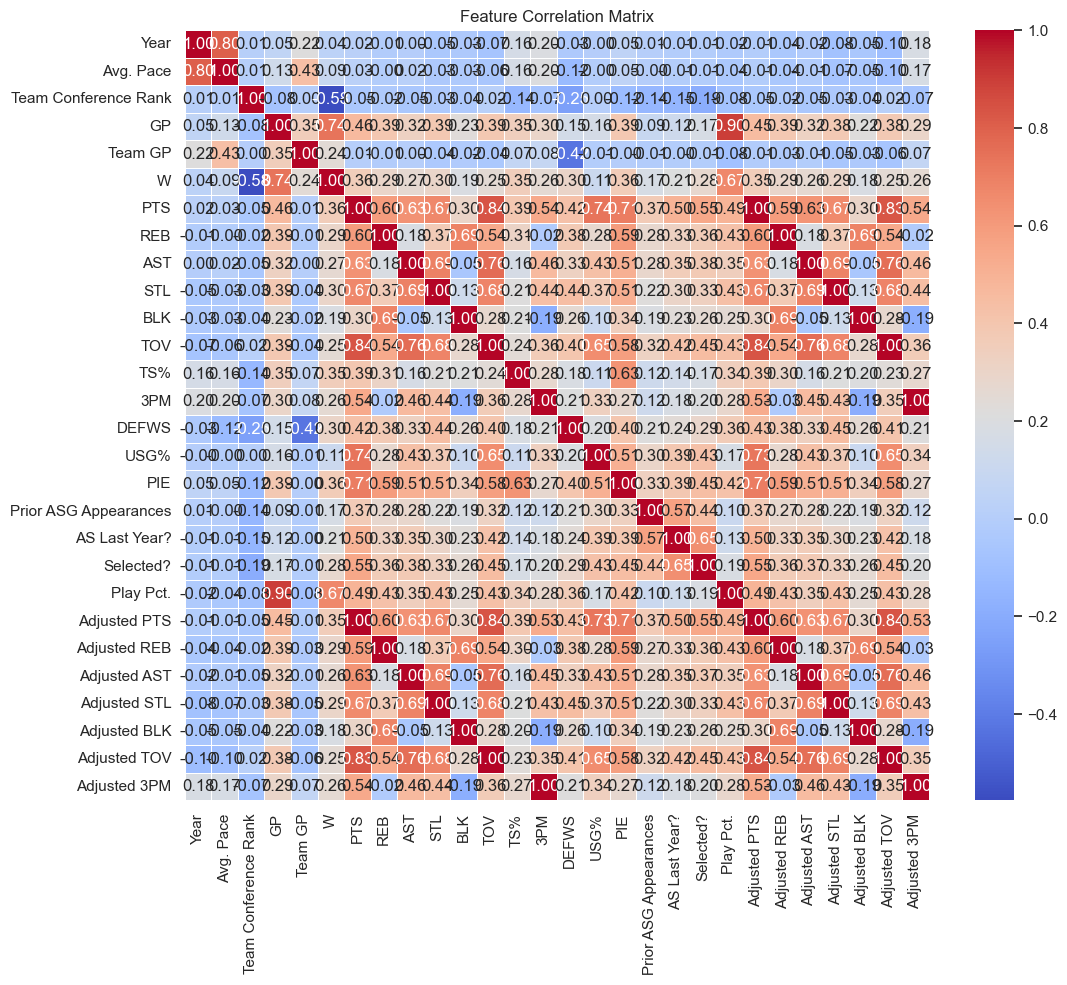

Selected?                1.000000
AS Last Year?            0.646030
Adjusted PTS             0.548259
PTS                      0.548201
TOV                      0.448488
Adjusted TOV             0.446661
PIE                      0.445188
Prior ASG Appearances    0.441096
USG%                     0.426295
AST                      0.375287
Adjusted AST             0.374238
REB                      0.359999
Adjusted REB             0.359939
STL                      0.333870
Adjusted STL             0.332623
DEFWS                    0.290931
W                        0.275037
BLK                      0.256293
Adjusted BLK             0.256065
Adjusted 3PM             0.202248
3PM                      0.202093
Play Pct.                0.186674
TS%                      0.173118
GP                       0.171374
Avg. Pace               -0.005274
Year                    -0.005806
Team GP                 -0.006788
Team Conference Rank    -0.188999
Name: Selected?, dtype: float64

In [550]:
# Select only numeric columns for correlation analysis
numeric_columns = df_train.select_dtypes(include=['number'])

# Compute the correlation matrix for numeric features
correlation_matrix = numeric_columns.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Extract correlations of the binary 'AWARDS' column with other features
awards_correlations = correlation_matrix['Selected?'].sort_values(ascending=False)
awards_correlations

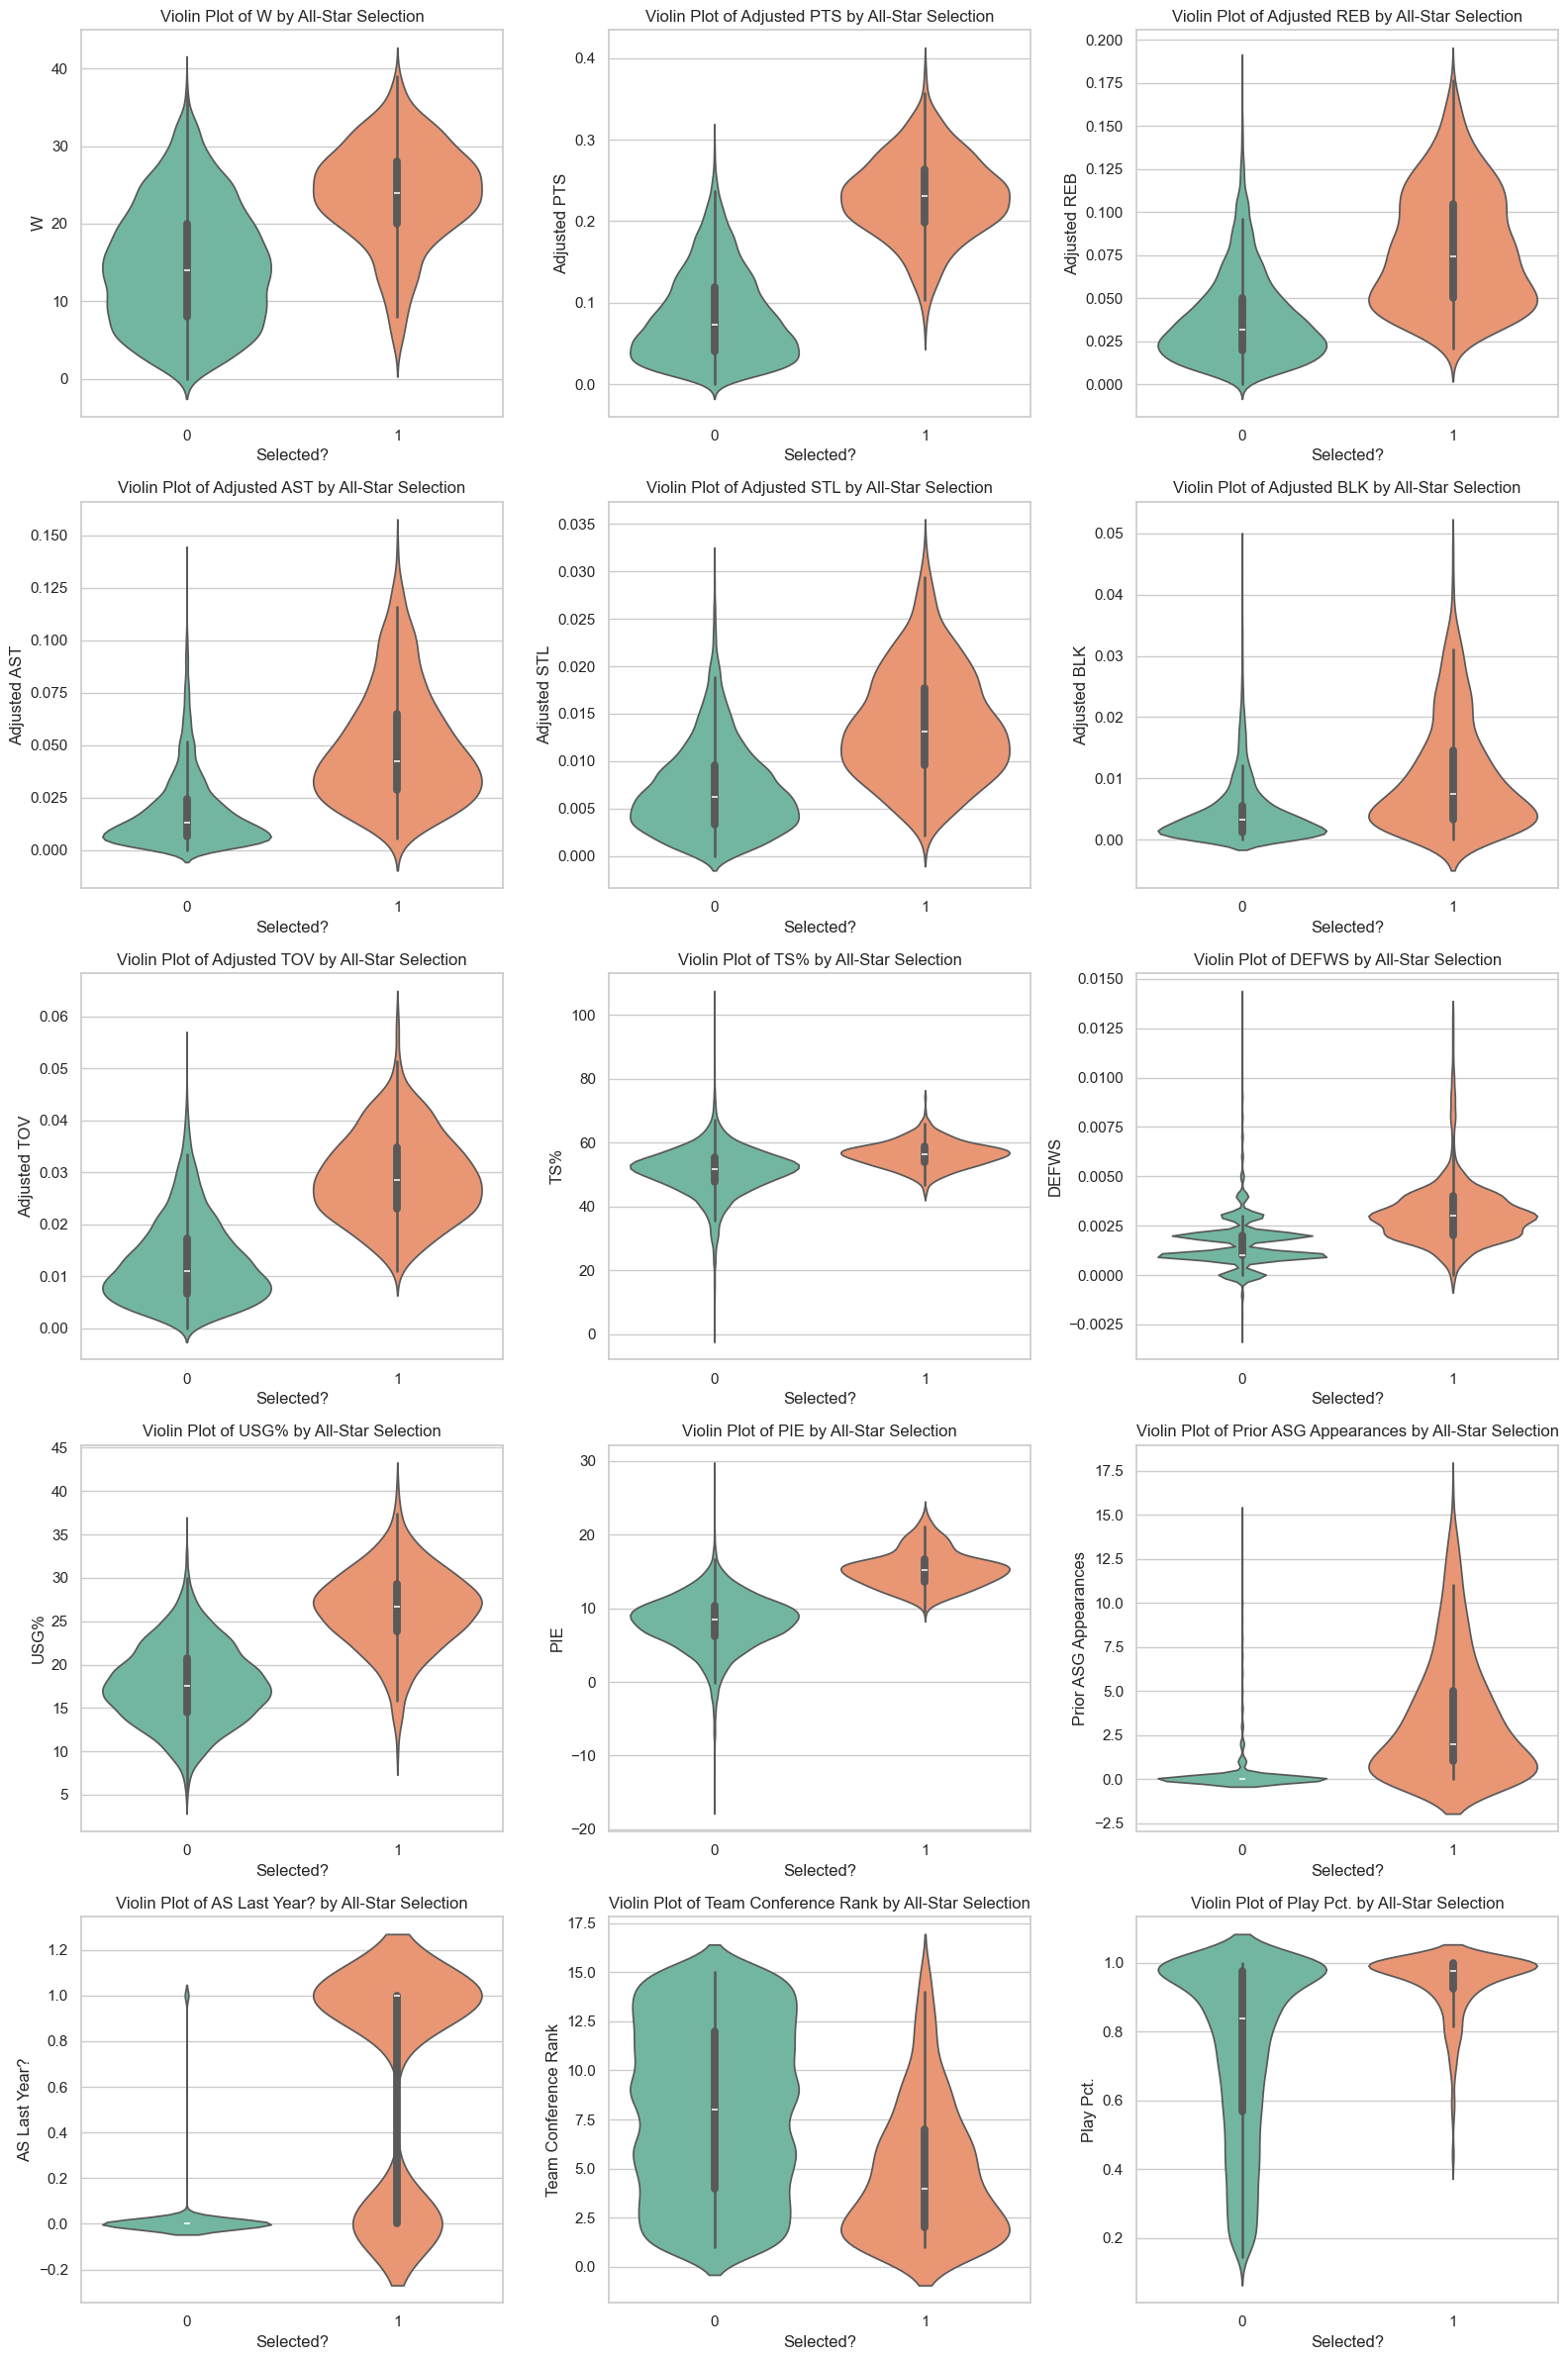

In [551]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of features for violin plots
features = [
    'W', 'Adjusted PTS', 'Adjusted REB', 'Adjusted AST', 'Adjusted STL',
    'Adjusted BLK', 'Adjusted TOV', 'TS%', 'DEFWS', 'USG%', 'PIE',
    'Prior ASG Appearances', 'AS Last Year?', 'Team Conference Rank', 'Play Pct.'
]

# Set the style
sns.set(style="whitegrid")

# Create violin plots for each feature
plt.figure(figsize=(16, 24))  # Adjust figure size to fit all plots
for i, feature in enumerate(features, 1):
    plt.subplot(5, 3, i)  # Create a 5x3 grid for subplots
    sns.violinplot(
        y=feature,       # Numeric feature to visualize
        x='Selected?',   # Categorical column for All-Star vs. Non-All-Star
        hue='Selected?', # Assign x variable to hue
        data=df_train,   # Replace with your DataFrame
        palette="Set2",  # Color palette
        dodge=False,     # Avoid separating the violins for each category
        legend=False     # Disable legend
    )
    plt.title(f"Violin Plot of {feature} by All-Star Selection")
    plt.ylabel(feature)
    plt.xlabel("Selected?")
plt.tight_layout()
plt.show()

### Step 4) Feature Selection & Scaling

In [553]:
selected_features = ['Adjusted PTS', 'Adjusted REB', 'Adjusted AST', 'Adjusted STL', 'Adjusted TOV', 'DEFWS', 
                     'USG%', 'PIE', 'Play Pct.', 'Team Conference Rank', 'Prior ASG Appearances', 'AS Last Year?']
target = 'Selected?'

# Assign X and y variables
X = df_train[selected_features]
y = df_train[target]

### Step 5) Baseline Models

We'll start with a simple logistic regression

In [556]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Non-All-Star', 'All-Star']))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on Test Set: 0.9777270131353513

Classification Report:
               precision    recall  f1-score   support

Non-All-Star       0.98      0.99      0.99      1640
    All-Star       0.88      0.76      0.81       111

    accuracy                           0.98      1751
   macro avg       0.93      0.87      0.90      1751
weighted avg       0.98      0.98      0.98      1751


Confusion Matrix:
 [[1628   12]
 [  27   84]]


In [557]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = decision_tree.predict(X_test)

# Evaluate the Decision Tree model
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
class_report_tree = classification_report(y_test, y_pred_tree, target_names=['Non-All-Star', 'All-Star'])

print(class_report_tree)

              precision    recall  f1-score   support

Non-All-Star       0.99      0.98      0.98      1640
    All-Star       0.74      0.80      0.77       111

    accuracy                           0.97      1751
   macro avg       0.86      0.89      0.88      1751
weighted avg       0.97      0.97      0.97      1751



Lets move on to our advanced models.

### Step 6) Advanced Models

Before we train our advanced models, we must deal with class imbalances since there are significantly less All-Stars than non-All-Stars. We can handle class imbalance using the SMOTE technique, which oversamples the minority class to achieved balance.

In [561]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Apply SMOTE only for KNN and XGBoost models
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [562]:
# XGBoost (with SMOTE)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_smote, y_smote)
xgb_pred = xgb_model.predict(X_test)

print("XGBoost:")
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_pred))
print("\n" + "-"*50 + "\n")

XGBoost:
Accuracy: 0.9771559109080525

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1640
           1       0.78      0.89      0.83       111

    accuracy                           0.98      1751
   macro avg       0.89      0.94      0.91      1751
weighted avg       0.98      0.98      0.98      1751


Confusion Matrix:
 [[1612   28]
 [  12   99]]

--------------------------------------------------



C:\Users\hamza\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [563]:
# K-Nearest Neighbors (with SMOTE)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_smote, y_smote)
knn_pred = knn_model.predict(X_test)

print("K-Nearest Neighbors:")
print("Accuracy:", accuracy_score(y_test, knn_pred))
print("\nClassification Report:\n", classification_report(y_test, knn_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, knn_pred))

K-Nearest Neighbors:
Accuracy: 0.9388920616790406

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97      1640
           1       0.51      0.93      0.66       111

    accuracy                           0.94      1751
   macro avg       0.75      0.93      0.81      1751
weighted avg       0.96      0.94      0.95      1751


Confusion Matrix:
 [[1541   99]
 [   8  103]]


In [564]:
# Random Forest (without SMOTE)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("\nClassification Report:\n", classification_report(y_test, rf_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred))
print("\n" + "-"*50 + "\n")

Random Forest:
Accuracy: 0.981724728726442

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1640
           1       0.88      0.82      0.85       111

    accuracy                           0.98      1751
   macro avg       0.94      0.91      0.92      1751
weighted avg       0.98      0.98      0.98      1751


Confusion Matrix:
 [[1628   12]
 [  20   91]]

--------------------------------------------------



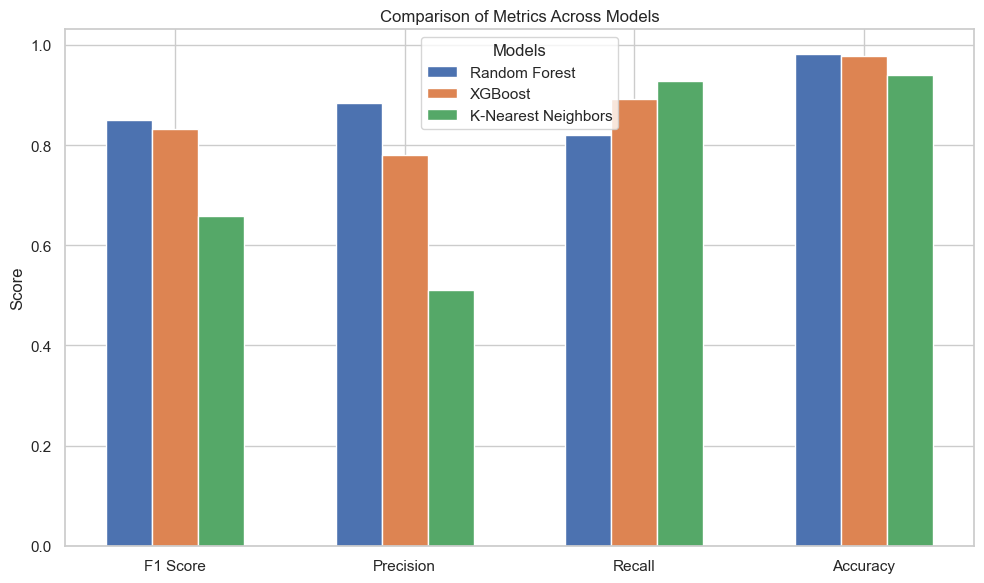

In [565]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Metrics for all models
metrics_data = {
    "Random Forest": [
        f1_score(y_test, rf_pred),
        precision_score(y_test, rf_pred),
        recall_score(y_test, rf_pred),
        accuracy_score(y_test, rf_pred),
    ],
    "XGBoost": [
        f1_score(y_test, xgb_pred),
        precision_score(y_test, xgb_pred),
        recall_score(y_test, xgb_pred),
        accuracy_score(y_test, xgb_pred),
    ],
    "K-Nearest Neighbors": [
        f1_score(y_test, knn_pred),
        precision_score(y_test, knn_pred),
        recall_score(y_test, knn_pred),
        accuracy_score(y_test, knn_pred),
    ],
}

metrics_labels = ["F1 Score", "Precision", "Recall", "Accuracy"]
models = list(metrics_data.keys())
metrics_values = np.array(list(metrics_data.values()))

# Bar chart
x = np.arange(len(metrics_labels))
width = 0.2

plt.figure(figsize=(10, 6))

for i, model in enumerate(models):
    plt.bar(x + i * width, metrics_values[i], width, label=model)

plt.xticks(x + width, metrics_labels)
plt.ylabel("Score")
plt.title("Comparison of Metrics Across Models")
plt.legend(title="Models")
plt.tight_layout()
plt.show()

What we can gather from these results is that the KNN model does not perform well enough, and while the other two models do perform well, we must tune their hyperparameters to see if we can get better results.

### Step 7) Hyperparameter Tuning

Lets start with our Random Forest model

In [637]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],           # Maximum depth of the tree 
    'bootstrap': [True, False],                 # Whether to use bootstrap samples
    'max_features': ['sqrt', 'log2', None]    # Number of features to consider when looking for the best split
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='f1',      # Use F1 score for optimization
    cv=3,              # 3-fold cross-validation
    verbose=2,
    n_jobs=-1          # Use all available CPU cores
)

# Fit GridSearchCV
grid_search.fit(X_smote, y_smote)

# Display the best parameters and the corresponding F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters for Random Forest:", best_params)
print("Best F1 Score from Grid Search:", best_f1_score)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Best F1 Score from Grid Search: 0.9858909982945695


In [641]:
# Train a Random Forest model with the specified parameters
rf_model_custom = RandomForestClassifier(
    bootstrap=False,
    max_depth=20,
    n_estimators=100,
    max_features='sqrt',
    random_state=42
)

# Fit the model on the SMOTE-balanced training data
rf_model_custom.fit(X_smote, y_smote)

# Make predictions on the test set
rf_pred_custom = rf_model_custom.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Performance with Specified Parameters:")
print("\nAccuracy:", accuracy_score(y_test, rf_pred_custom))
print("\nF1 Score:", f1_score(y_test, rf_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, rf_pred_custom))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, rf_pred_custom))

Random Forest Performance with Specified Parameters:

Accuracy: 0.9737292975442604

F1 Score: 0.8050847457627118

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1640
           1       0.76      0.86      0.81       111

    accuracy                           0.97      1751
   macro avg       0.88      0.92      0.90      1751
weighted avg       0.98      0.97      0.97      1751


Confusion Matrix:
 [[1610   30]
 [  16   95]]


Next, we move on to our XGBoost

In [609]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],            # Number of boosting rounds
    'max_depth': [3, 6, 10],                  # Maximum depth of the trees
    'learning_rate': [0.01, 0.1, 0.2],        # Step size shrinkage
    'reg_alpha': [0, 0.1, 1],                 # L1 regularization term
    'reg_lambda': [1, 2, 5]                   # L2 regularization term
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',      # Use F1 score for optimization
    cv=3,              # 3-fold cross-validation
    verbose=2,
    n_jobs=-1          # Use all available CPU cores
)

# Fit GridSearchCV
grid_search.fit(X_smote, y_smote)

# Display the best parameters and the corresponding F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters for XGBoost:", best_params)
print("Best F1 Score from Grid Search:", best_f1_score)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


C:\Users\hamza\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\hamza\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best F1 Score from Grid Search: 0.9859524334850261


In [611]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Define the best parameters for XGBoost
best_params = {
    'learning_rate': 0.2,
    'max_depth': 10,
    'n_estimators': 200,
    'reg_alpha': 0.1, 
    'reg_lambda': 1
}

# Initialize the XGBoost model with the best parameters
xgb_model = XGBClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_smote, y_smote)

# Test the model
xgb_pred = xgb_model.predict(X_test)

C:\Users\hamza\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [619]:
print("XGBoost Performance with Best Parameters:")
print("\nAccuracy:", accuracy_score(y_test, xgb_pred))
print("\nF1 Score:", f1_score(y_test, xgb_pred))
print("\nClassification Report:\n", classification_report(y_test, xgb_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

XGBoost Performance with Best Parameters:

Accuracy: 0.9743003997715591

F1 Score: 0.8132780082987552

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1640
           1       0.75      0.88      0.81       111

    accuracy                           0.97      1751
   macro avg       0.87      0.93      0.90      1751
weighted avg       0.98      0.97      0.98      1751


Confusion Matrix:
 [[1608   32]
 [  13   98]]


Finally, we tune our KNN model

In [625]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7, 8, 9],          # Number of neighbors to test
    'weights': ['uniform', 'distance'],       # Weighting scheme
    'metric': ['euclidean', 'manhattan']      # Distance metric
}

# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring='f1',      # Optimize for F1 score
    cv=3,              # 3-fold cross-validation
    verbose=2,
    n_jobs=-1          # Use all available CPU cores
)

# Fit GridSearchCV
grid_search.fit(X_smote, y_smote)

# Display the best parameters and the corresponding F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best Parameters for KNN:", best_params)
print("Best F1 Score from Grid Search:", best_f1_score)

Fitting 3 folds for each of 28 candidates, totalling 84 fits
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
Best F1 Score from Grid Search: 0.9673883888243644


In [631]:
# Train a KNN model with the specified parameters
knn_model_custom = KNeighborsClassifier(
    metric='euclidean',
    n_neighbors=4,
    weights='distance'
)

# Fit the model on the SMOTE-balanced training data
knn_model_custom.fit(X_smote, y_smote)

# Make predictions on the test set
knn_pred_custom = knn_model_custom.predict(X_test)

# Evaluate the KNN model
print("KNN Performance with Specified Parameters:")
print("\nAccuracy:", accuracy_score(y_test, knn_pred_custom))
print("\nF1 Score:", f1_score(y_test, knn_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, knn_pred_custom))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, knn_pred_custom))

KNN Performance with Specified Parameters:

Accuracy: 0.9440319817247287

F1 Score: 0.6597222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1640
           1       0.54      0.86      0.66       111

    accuracy                           0.94      1751
   macro avg       0.76      0.90      0.81      1751
weighted avg       0.96      0.94      0.95      1751


Confusion Matrix:
 [[1558   82]
 [  16   95]]


It seems our XGBoost algorithm performs the best on our testing data, with an accuracy of 0.9743 and an F1 Score of 0.8132.

Let's test it to see how it performs on unlabeled data from the 2020 season and compare it with the real results

### Step 8) Results

In [652]:
# Ensure the prediction dataset and features are prepared
selected_features = [
    'Adjusted PTS', 'Adjusted REB', 'Adjusted AST', 'Adjusted STL',
    'Adjusted TOV', 'DEFWS', 'USG%', 'PIE', 'Play Pct.',
    'Team Conference Rank', 'Prior ASG Appearances', 'AS Last Year?'
]

# Extract features for prediction
X_to_predict = df_to_predict[selected_features]

# Generate All-Star probabilities using the trained XGBoost model
df_to_predict['AS Prob.'] = [prob[1] for prob in xgb_model.predict_proba(X_to_predict)]

# Ensure TEAM column exists for conference mapping (validate the dataset contains TEAM)
eastern_conference = set([
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DET', 'IND', 'MIA',
    'MIL', 'NYK', 'ORL', 'PHI', 'TOR', 'WAS'
])

# Assign conference based on team
df_to_predict['Conf.'] = df_to_predict['TEAM'].map(lambda x: 'East' if x in eastern_conference else 'West')

# Split by conference
df_east = df_to_predict[df_to_predict['Conf.'] == 'East'].sort_values('AS Prob.', ascending=False).reset_index(drop=True)
df_west = df_to_predict[df_to_predict['Conf.'] == 'West'].sort_values('AS Prob.', ascending=False).reset_index(drop=True)

# Predict top 12 players for each conference
for df in [df_east, df_west]:
    df['Model Prediction'] = df.index.map(lambda x: 'Yes' if x < 12 else 'No')

# Select relevant columns
df_east = df_east[['PLAYER', 'TEAM', 'Conf.', 'AS Prob.', 'Model Prediction']]
df_west = df_west[['PLAYER', 'TEAM', 'Conf.', 'AS Prob.', 'Model Prediction']]

# Top x players per conference for the summary
summary_conf_size = 25
df_results_summary = pd.concat([df_east.head(summary_conf_size), df_west.head(summary_conf_size)]).set_index('PLAYER')

# Save results to CSV files (optional)
df_results_summary.to_csv('NBA_ASG_predictor_results_summary.csv', index=True)

# Display the summary for visualization
print(df_results_summary)

                        TEAM Conf.  AS Prob. Model Prediction
PLAYER                                                       
Giannis Antetokounmpo    MIL  East  0.999993              Yes
Khris Middleton          MIL  East  0.999828              Yes
Jimmy Butler             MIA  East  0.998914              Yes
Kyle Lowry               TOR  East  0.993076              Yes
Ben Simmons              PHI  East  0.992983              Yes
Trae Young               ATL  East  0.991360              Yes
Jayson Tatum             BOS  East  0.989902              Yes
Kemba Walker             BOS  East  0.984551              Yes
Zach LaVine              CHI  East  0.914451              Yes
Domantas Sabonis         IND  East  0.885239              Yes
Pascal Siakam            TOR  East  0.848398              Yes
Joel Embiid              PHI  East  0.844734              Yes
Jaylen Brown             BOS  East  0.823982               No
Bam Adebayo              MIA  East  0.817002               No
Kyrie Ir

From the Eastern Conference, the model correctly predicted **11** of **12** All-Star selections.

From the Western Conference, the model correctly predicted **10** of **13** All-Star selections.

In total, our XGBoost model correctly predicted **21** of **25** All-Star selections.